In [1]:
import os
from pyspark.sql import SparkSession
# Import PandasUDFType from the corrected location (functions)
from pyspark.sql.functions import PandasUDFType 

# Set environment variables for the current notebook kernel
user_home = os.environ['HOME']
java_target_dir = os.path.join(user_home, "java_home")
java_bin_dir = os.path.join(java_target_dir, "bin")

os.environ["JAVA_HOME"] = java_target_dir
os.environ["PATH"] = java_bin_dir + os.pathsep + os.environ["PATH"]

# Initialize Spark Session with Optimal Memory Settings for 32 Cores
# Total RAM: 224G. Driver: 16G. Executor: ~200G. Cores: 30.
spark = SparkSession.builder \
    .appName("Parallel_MCMC_Model_Fit") \
    .master("local[*]") \
    .config("spark.executor.cores", "30") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "200g") \
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.python.worker.memory", "6g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()
    
print(f"Spark Session initialized! Driver: 16G, Executor: 200G, Cores: 30.")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/07 16:12:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Session initialized! Driver: 16G, Executor: 200G, Cores: 30.


In [2]:
import pandas as pd
import numpy as np
import re
from functools import reduce
from sklearn.linear_model import ElasticNetCV
import matplotlib.pyplot as plt
from pyspark.sql.functions import pandas_udf, col, lit
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
from pyspark.sql.functions import PandasUDFType

In [ ]:
xml_path = "segment4_cattle.xml"
rates_path = "log_rates.csv"

# Define the schema for the output of the parallel UDF
# The UDF will output a table with columns: (mcmc_state, predictor, coef)
output_schema = StructType([
    StructField("mcmc_state", StringType(), True),
    StructField("predictor", StringType(), True),
    StructField("coef", DoubleType(), True) # <-- CORRECTED FIELD NAME
])

# Load transition rates (still best in Pandas for simple I/O)
transition_df = pd.read_csv(rates_path, index_col=0)

In [ ]:
# Extract states from XML 
xml_districts = []
read_loc = False
with open(xml_path, 'r') as f:
    for line in f:
        if 'state.dataType' in line:
            read_loc = True
        m = re.search(r'<state code="([A-Za-z_]+)"/>', line)
        if read_loc and m:
            xml_districts.append(m.group(1))

print(f"\nNumber of datatypes: {len(xml_districts)}")


EXCLUDE_PREDICTORS = ["state.swine_trade_exp_origin_offsetlog","state.swine_trade_exp_destination_offsetlog",
                      "state.total_swine_stock_destination_logtransform","state.total_swine_stock_origin_logtransform",
                      "state.capital_distance_km_offsetlog"]

# EXCLUDE_PREDICTORS = []

def should_exclude(pred_name):
    return any(ex in pred_name for ex in EXCLUDE_PREDICTORS)


# Extract predictor matrices from XML
predictor_matrices = {}
pattern = re.compile(r'<parameter id="([A-Za-z0-9_.]+)" value="([0-9.\- E]+)"')
design_matrix = False
counter = 0
N = len(xml_districts)

with open(xml_path, 'r') as f:
    for line in f:
        if '<designMatrix' in line:
            design_matrix = True
        if design_matrix:
            found = pattern.search(line)
            if found:
                pred_name = found.group(1)

                if should_exclude(pred_name):
                    continue


                values = list(map(float, found.group(2).split()))
                if len(values) == (N*N - N): # N*(N-1)
                    predictor_matrices[pred_name] = values
                    counter += 1

print(f"\n Predictors found in file: {counter}")

# Reshape and merge 
predictor_dfs = []

for name, flat_vec in predictor_matrices.items():
    # Convert flat vector into full square matrix with NaN diagonal
    mat = np.zeros((N, N))
    mat[:] = np.nan
    idx = 0
    for i in range(N):
        for j in range(N):
            if i != j:
                mat[i, j] = flat_vec[idx]
                idx += 1

    # Convert to DataFrame + melt into long dyadic format
    df = pd.DataFrame(mat, index=xml_districts, columns=xml_districts)
    long_df = (
        df.reset_index()
          .melt(id_vars="index", var_name="destination", value_name=name)
          .rename(columns={"index": "origin"})
    )
    predictor_dfs.append(long_df)

# Merge all predictors into one dyadic table
predictors_df = reduce(lambda left, right: pd.merge(left, right, on=["origin", "destination"]),
                         predictor_dfs)

print(f"Predictor matrix shape (from XML): {predictors_df.shape}")

# Merge with transition rates
merged_pd = transition_df.merge(predictors_df, on=["origin", "destination"], how="inner")
print(f"Merged data shape: {merged_pd.shape}")

# Identify predictor columns for the model
predictor_cols = [c for c in predictors_df.columns if c not in ["origin", "destination"]]

# clean column names
# Replace dots with underscores to prevent Spark AnalysisException
merged_pd.columns = [c.replace('.', '_') for c in merged_pd.columns]
predictors_df.columns = [c.replace('.', '_') for c in predictors_df.columns]
predictor_cols = [c.replace('.', '_') for c in predictor_cols]

# Re-initialize the list of predictor columns for the UDF, excluding the target and key variables.
EXCLUDED_COLS = ["origin", "destination", "mcmc_state", "transition_rate", "migration_count", "total_branch_length", "log_transition_rate", "log_migration_count"]

# Also exclude predictors just in case
EXCLUDED_COLS.extend([ex.replace('.', '_') for ex in EXCLUDE_PREDICTORS])


predictor_cols = [c for c in merged_pd.columns if c not in EXCLUDED_COLS]
print(f"Cleaned predictor columns count: {len(predictor_cols)}")



Number of datatypes: 14

 Predictors found in file: 16
Predictor matrix shape (from XML): (196, 18)
Merged data shape: (16380182, 24)
Cleaned predictor columns count: 16


In [5]:
# Ensure 'mcmc_state' is a string type for Spark/Arrow compatibility
merged_pd['mcmc_state'] = merged_pd['mcmc_state'].astype(str)
print(f"MCMC state dtype converted to: {merged_pd['mcmc_state'].dtype}")

# Convert the final Pandas DataFrame into a Spark DataFrame
merged_spark = spark.createDataFrame(merged_pd)

print("Data frame converted")

MCMC state dtype converted to: object
Data frame converted


In [ ]:
def fit_elastic_net(pdf: pd.DataFrame) -> pd.DataFrame:
    """
    Fits an Elastic Net regression model with cross-validation to data
    from a single MCMC state group.

    Args:
        pdf (pandas.DataFrame): A DataFrame containing data for exactly one
            MCMC state group. Must include the columns "mcmc_state",
            "log_transition_rate", and all predictors specified in
            `predictor_cols`.

    Returns:
        pandas.DataFrame: A DataFrame containing the fitted Elastic Net
            coefficients with the following columns:
            - mcmc_state: Identifier of the MCMC state.
            - predictor: Name of the predictor variable.
            - coef: Estimated coefficient value for the predictor.
            If the response variable has zero variance, an empty DataFrame
            with the appropriate columns is returned.

    Docstring generated with ChatGPT 5.2.
    """

    state_id = pdf["mcmc_state"].iloc[0]
    
    X = pdf[predictor_cols].values
    y = pdf["log_transition_rate"].values
    
    # Skip if response has no variance
    if np.std(y) == 0:
        return pd.DataFrame([], columns=["mcmc_state", "predictor", "coef"])
    
    # Elastic Net Model with Cross-Validation
    model = ElasticNetCV(
        l1_ratio=0.5, 
        cv=5, 
        n_alphas=100, 
        random_state=42, 
        max_iter=5000
    )
    
    model.fit(X, y)
    
    # Create the output dataframe of coefficients
    coef_df = pd.DataFrame({
        "mcmc_state": state_id,
        "predictor": predictor_cols,
        # ElasticNetCV stores coefficients in model.coef_
        "coef": model.coef_
    })
    
    return coef_df

# Apply the UDF to the Spark DataFrame grouped by mcmc_state
# The function is passed directly, and the output schema is the second argument.
imp_spark = merged_spark.groupBy("mcmc_state").applyInPandas(fit_elastic_net, output_schema)

# Collect the results back to the driver as a Pandas DataFrame for final analysis
imp_df = imp_spark.toPandas()

print(f"\nTotal coefficient records collected: {len(imp_df)}")

25/12/07 16:13:40 WARN TaskSetManager: Stage 0 contains a task of very large size (1963 KiB). The maximum recommended task size is 1000 KiB.



Total coefficient records collected: 1440016



Elastic Net summary across MCMC replicates:
                                            predictor  selected_freq  \
14  state_yearly_precipitation_destination_logtran...       0.910157   
1            state_GDP_per_capita_origin_logtransform       0.830746   
13       state_total_cattle_stock_origin_logtransform       0.759636   
3            state_agro_land_perc_origin_logtransform       0.759369   
8    state_mean_temperatures_destination_logtransform       0.752469   
12  state_total_cattle_stock_destination_logtransform       0.745669   
9         state_mean_temperatures_origin_logtransform       0.745281   
0       state_GDP_per_capita_destination_logtransform       0.745269   
4        state_cattle_trade_exp_destination_offsetlog       0.736481   
11               state_num_of_seq_origin_logtransform       0.726747   
10          state_num_of_seq_destination_logtransform       0.726403   
5             state_cattle_trade_exp_origin_offsetlog       0.014311   
15     state_yearly

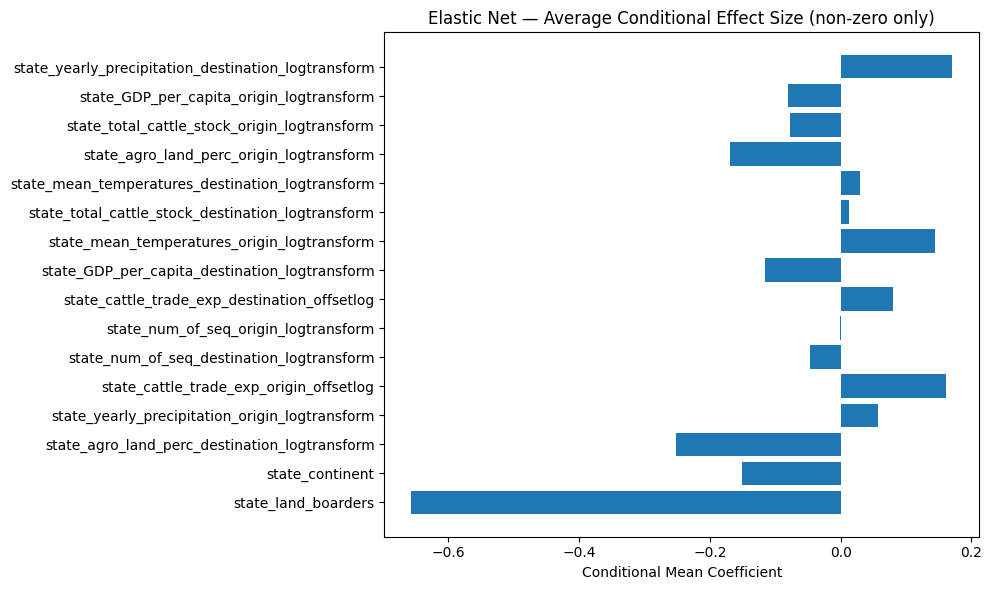

In [ ]:
# ELASTIC NET SUMMARY AND VISUALIZATION 


# HPD Calculation

def compute_hpd_str(series, alpha=0.95):
    """
    Computes the Highest Posterior Density (HPD) interval and returns it
    as a formatted string.

    Args:
        series (pandas.Series): Input data series from which to compute the HPD interval.
            Missing values are automatically dropped.
        alpha (float, optional): Credible mass of the HPD interval. Defaults to 0.95.

    Returns:
        str: A formatted string representing the HPD interval in the form
            "[low, high]" with four decimal places. If the input series
            contains no valid values, returns "[-,-]".

    Docstring generated with ChatGPT 5.2.
    """
    x = series.dropna().values
    n = len(x)
    if n == 0:
        return "[-,-]"
    
    # Sort the data to calculate intervals
    x = np.sort(x)
    
    # Number of data points that make up the alpha% mass
    n_points = int(np.floor(alpha * n))

    # Calculate widths of all possible intervals of size n_points
    intervals_starts = x[:n - n_points]
    intervals_ends = x[n_points:]
    widths = intervals_ends - intervals_starts

    # Find the index of the minimum width (narrowest interval)
    min_idx = np.argmin(widths)
    
    low = intervals_starts[min_idx]
    high = intervals_ends[min_idx]
    
    # Format
    return f"[{low:.4f}, {high:.4f}]"

# Use the results collected from Spark (imp_df) for analysis.
coef_df = imp_df.rename(columns={'coef': 'coef'}) 

# Selection Frequency: fraction of replicates with non-zero coefficient
# threshold close to zero
ZERO_TOLERANCE = 1e-9

selection_freq = coef_df.groupby("predictor") \
    .apply(lambda x: np.mean(np.abs(x["coef"]) > ZERO_TOLERANCE)) \
    .rename("selected_freq")

# Create a subset of ONLY non-zero coefficients
non_zero_df = coef_df[np.abs(coef_df["coef"]) > ZERO_TOLERANCE]

# Conditional Mean: mean coefficient only when selected (non-zero)
conditional_mean = non_zero_df.groupby("predictor")["coef"] \
    .mean().rename("conditional_mean")

# Conditional 95% HPD (non-zero only)
# We apply the HPD function only to the non-zero subset
hpd_interval = non_zero_df.groupby("predictor")["coef"] \
    .apply(compute_hpd_str) \
    .rename("conditional_95_hpd")

# Combine all stat summaries
enet_summary = pd.concat([selection_freq, conditional_mean, hpd_interval], axis=1).reset_index()

# Fill NA for predictors that were never selected
# Predictors never selected will have NaN for conditional_mean, which is correctly 0.
enet_summary["conditional_mean"] = enet_summary["conditional_mean"].fillna(0)

# Sort by frequency then effect size
enet_summary = enet_summary.sort_values(
    ["selected_freq", "conditional_mean"], ascending=False
)

# summary
print("\nElastic Net summary across MCMC replicates:")
print(enet_summary)

enet_summary.to_csv("res_log/enet_cow_excl.csv", index=False)
print("Saved summary to enet_cow_excl.csv")

# Bar Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Filter out predictors that have zero frequency and zero conditional mean for cleaner visualization
plot_df = enet_summary[enet_summary['selected_freq'] > 0]

plt.barh(plot_df["predictor"], plot_df["conditional_mean"])
plt.xlabel("Conditional Mean Coefficient")
plt.title("Elastic Net — Average Conditional Effect Size (non-zero only)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("res_log/enet_cow_excl.png", dpi=300)
plt.show()

# Stop the Spark Session when done
spark.stop()